In [39]:
import tqdm
import torch
import torch.nn as nn
import numpy as np
from matplotlib import pyplot as plt
import requests
import dvc.api
import pandas as pd
import pickle
import scipy.stats as ss
from matplotlib.patches import Ellipse
import math

In [40]:
SEED = 42
np.random.seed(SEED)

In [41]:
def plotmixturenorm(norm_params, size = 10):
    mixture_idx = np.random.choice(norm_params.shape[0], size=size, replace=True)
    y = [ss.multivariate_normal.rvs(norm_params[i][0], np.diag(norm_params[i][1])) for i in mixture_idx]
    return np.array(y), mixture_idx

In [42]:
def getmeans(dim, clusters):
    return ss.multivariate_normal.rvs(np.zeros(dim), 12, clusters)

In [43]:
def getstd(dim, clusters):
    return np.abs(ss.multivariate_normal.rvs(np.zeros(dim), 1, clusters))

In [44]:
input_dim = 2
num_clusters = 2
m = getmeans(input_dim, num_clusters)
std = getstd(input_dim, num_clusters)

params = np.stack((m, std), axis = 1)
num_points = 10000
data = plotmixturenorm(params, size = num_points)

dataset = pd.DataFrame()
dataset['coord0'] = data[0][:, 0]
dataset['coord1'] = data[0][:, 1]
dataset['label'] = data[1]

In [45]:
dataset

,coord0,coord1,label
0,2.891212,4.545071,1
1,2.777540,-0.202906,0
2,1.513977,4.740336,1
3,2.126859,5.066118,1
4,3.647147,5.439237,1
...,...,...,...
9995,1.051788,0.025306,0
9996,1.829147,-0.697595,0
9997,2.819869,-1.276512,0
9998,3.469678,5.178282,1


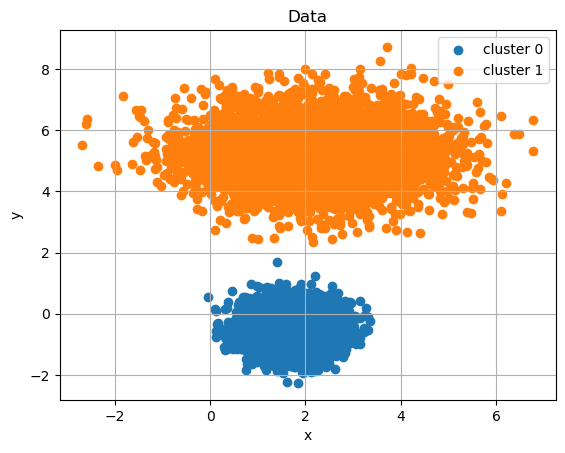

In [46]:
fig, ax = plt.subplots()

ax.scatter(dataset['coord0'][dataset['label'] == 0], dataset['coord1'][dataset['label'] == 0], label='cluster 0')
ax.scatter(dataset['coord0'][dataset['label'] == 1], dataset['coord1'][dataset['label'] == 1], label='cluster 1')

ax.legend()
ax.grid()
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Data');

In [47]:
dataset[['coord0','coord1']].values

array([[ 2.89121246,  4.54507135],
       [ 2.77753954, -0.20290627],
       [ 1.51397715,  4.74033621],
       ...,
       [ 2.81986948, -1.27651173],
       [ 3.46967774,  5.17828216],
       [ 2.10054782, -0.42624139]])

In [48]:
test_ratio = 0.2
X_train = dataset[['coord0','coord1']].values[:int(num_points * (1 - test_ratio))].astype(np.float32)
X_test = dataset[['coord0','coord1']].values[int(num_points * (1 - test_ratio)):].astype(np.float32)

In [49]:
class VAE(torch.nn.Module):
    @property
    def device(self):
        return next(self.parameters()).device

    def __init__(self, latent_dim, input_dim, hidden_dim=200):
        """
        Standart model of VAE with ELBO optimization.
        Args:
            latent_dim: int - the dimension of latent space.
            input_dim: int - the dimension of input space.
            hidden_dim: int - the size of hidden_dim neural layer.
        Returns:
            None
        Example:
            >>> model = VAE(2, 10)
        """
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.proposal_z = torch.nn.Sequential(
            torch.nn.Linear(self.input_dim, hidden_dim),
            torch.nn.LeakyReLU(),
        )
        self.proposal_mu = torch.nn.Linear(hidden_dim, self.latent_dim)
        self.proposal_sigma = torch.nn.Linear(hidden_dim, self.latent_dim)

        self.generative_network_mu = torch.nn.Sequential(
            torch.nn.Linear(self.latent_dim, hidden_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(hidden_dim, self.input_dim),
        )

        self.generative_network_sigma = torch.nn.Sequential(
            torch.nn.Linear(self.latent_dim, hidden_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(hidden_dim, self.input_dim),
        )

    def q_z(self, x):
        """
        Generates distribution of z provided x.
        Args:
            x: Tensor - the matrix of shape batch_size x input_dim.
        Returns:
            tuple(Tensor, Tensor) - the normal distribution parameters.
            mu: Tensor - the matrix of shape batch_size x latent_dim.
            sigma: Tensor - the matrix of shape batch_size x latent_dim.
        Example:
            >>>
        """
        x = x.to(self.device)

        proposal = self.proposal_z(x)
        mu = self.proposal_mu(proposal)
        sigma = torch.nn.Softplus()(self.proposal_sigma(proposal))
        return mu, sigma

    def p_z(self, num_samples):
        """
        Generetes prior distribution of z.
        Args:
            num_samples: int - the number of samples.
        Returns:
            tuple(Tensor, Tensor) - the normal distribution parameters.
                mu: Tensor - the matrix of shape num_samples x latent_dim.
            	sigma: Tensor - the matrix of shape num_samples x latent_dim.
        Example:
            >>>
        """
        mu = torch.zeros([num_samples, self.latent_dim], device=self.device)
        sigma = torch.ones([num_samples, self.latent_dim], device=self.device)
        return mu, sigma

    def sample_z(self, distr, num_samples=1):
        """
        Generates samples from normal distribution q(z|x).
        Args:
            distr = (mu, sigma): tuple(Tensor, Tensor) - the normal distribution parameters.
                mu: Tensor - the matrix of shape batch_size x latent_dim.
                sigma: Tensor - the matrix of shape batch_size x latent_dim.
            num_samples: int - the number of samples for each element.
        Returns:
            Tensor - the tensor of shape batch_size x num_samples x latent_dim - samples from normal distribution in latent space.
        Example:
            >>>
        """
        mu, sigma = distr
        mu = mu.to(self.device)
        sigma = sigma.to(self.device)

        batch_size = mu.shape[0]

        bias = mu.view([batch_size, 1, self.latent_dim])

        epsilon = torch.randn([batch_size, num_samples, self.latent_dim],
                              requires_grad=True,
                              device=self.device)
        scale = sigma.view([batch_size, 1, self.latent_dim])

        return bias + epsilon * scale

    def q_x(self, z):
        """
        Given the latent representation matrix z, returns the matrix of Bernoulli distribution parameters for sampling x objects.
        Args:
            z: Tensor - the tensor of shape batch_size x num_samples x latent_dim, samples from latent space.
        Returns:
            Tensor - the tensor of shape batch_size x num_samples x input_dim, Bernoulli distribution parameters.
        Example:
            >>>
        """ 
        z = z.to(self.device)
        out_mu = self.generative_network_mu(z)
        out_sigma = torch.nn.Softplus()(self.generative_network_mu(z))
        return out_mu, out_sigma

    def loss(self, batch_x, batch_y):
        """
        Calculate ELBO approximation of log likelihood for given batch with negative sign.
        Args:
            batch_x: FloatTensor - the matrix of shape batch_size x input_dim.
            batch_y: FloatTensor - dont uses parameter in this model.
        Returns:
            Tensor - scalar, ELBO approximation of log likelihood for given batch with negative sign.
        Example:
            >>>
        """
        batch_x = batch_x.to(self.device)
        batch_y = batch_y.to(self.device)

        batch_size = batch_x.shape[0]

        propos_distr = self.q_z(batch_x)
        pri_distr = self.p_z(batch_size)

        x_distr = self.q_x(self.sample_z(propos_distr))

        expectation = torch.mean(
            self.log_mean_exp(
                self.log_likelihood(
                    batch_x, x_distr)), dim=0)

        divergence = self.divergence_KL_normal(propos_distr, pri_distr)

        return -1 * torch.mean(expectation - divergence, dim=0)

    def generate_samples(self, num_samples):
        """
        Generate samples of object x from noises in latent space.
        Args:
            num_samples: int - the number of samples, witch need to generate.
        Returns:
            Tensor - the matrix of shape num_samples x input_dim.
        Example:
            >>>
        """
        distr_z = self.p_z(num_samples=1)

        z = self.sample_z(distr_z, num_samples=num_samples)

        distr_x_mu, dist_x_std = self.q_x(z)
        distr_x_mu, dist_x_std = distr_x_mu.view([num_samples, -1]), dist_x_std.view([num_samples, -1])
        return torch.normal(distr_x_mu, dist_x_std).to(self.device)

    @staticmethod
    def log_pdf_normal(distr, samples):
        """
        The function calculates the logarithm of the probability density at a point relative to the corresponding normal distribution given componentwise by its mean and standard deviation.
        Args:
            distr = (mu, sigma): tuple(Tensor, Tensor) - the normal distribution parameters.
                mu: Tensor - the matrix of shape batch_size x latent_dim.
                sigma: Tensor - the matrix of shape batch_size x latent_dim.
            samples: Tensor - the tensor of shape batch_size x num_samples x latent_dim, samples in latent space.
        Returns:
            Tensor - the matrix of shape batch_size x num_samples, each element of which is the logarithm of the probability density of a point relative to the corresponding distribution.
        Example:
            >>>
        """
        mu, sigma = distr

        batch_size = mu.shape[0]
        latent_dim = mu.shape[1]

        f1 = torch.sum(((samples -
                         mu.view([batch_size, 1, latent_dim]))**2) /
                       sigma.view([batch_size, 1, latent_dim])**2, dim=2)
        f2 = mu.shape[1] * (math.log(2) + math.log(math.pi))
        f3 = torch.sum(torch.log(sigma), dim=1).view(batch_size, 1)
        return -0.5 * (f1 + f2) - f3

    @staticmethod
    def log_likelihood(x_true, x_distr):
        """
        Calculate log likelihood between x_true and x_distr.
        Args:
            x_true:  Tensor - the matrix of shape batch_size x input_dim.
            x_distr: Tensor - the tensor of shape batch_size x num_samples x input_dim, Bernoulli distribution parameters.
        Returns:
            Tensor - the matrix of shape batch_size x num_samples - log likelihood for each sample.
        Example:
            >>>
        """
        mu, sigma = x_distr
        batch_size = mu.shape[0]
        input_dim = mu.shape[2]

       
        f1 = torch.sum(((x_true -
                         mu)**2) /
                       sigma**2, dim=2)
        f2 = input_dim * (math.log(2) + math.log(math.pi))
        f3 = torch.sum(torch.log(sigma), dim=(1, 2)).view(batch_size, 1)
        return -0.5 * (f1 + f2) - f3
    
        batch_size = x_distr.shape[0]
        input_dim = x_distr.shape[2]

        bernoulli_log_likelihood = torch.log(
            x_distr) * x_true.view([batch_size, 1, input_dim])
        bernoulli_log_likelihood += torch.log(1 - x_distr) * (
            1 - x_true).view([batch_size, 1, input_dim])

        return torch.sum(bernoulli_log_likelihood, dim=2)

    @staticmethod
    def log_mean_exp(data):
        """
        Args:
            data: Tensor - the tensor of shape n_1 x n_2 x ... x n_K.
        Returns:
            Tensor - the tensor of shape n_1 x n_2 x ,,, x n_{K - 1}.
        Example:
            >>>
        """

        return torch.logsumexp(data, dim=-1) - \
            torch.log(torch.Tensor([data.shape[-1]]).to(data.device))

    @staticmethod
    def divergence_KL_normal(q_distr, p_distr):
        """
        Calculate KL-divergence KL(q||p) between n-pairs of normal distribution.
        Args:
            q_distr=(mu, sigma): tuple(Tensor, Tensor) - the normal distribution parameters.
                mu: Tensor - the matrix of shape batch_size x latent_dim.
                sigma: Tensor - the matrix of shape batch_size x latent_dim.
            p_distr=(mu, sigma): tuple(Tensor, Tensor) - the normal distribution parameters.
                mu: Tensor - the matrix of shape batch_size x latent_dim.
                sigma: Tensor - the matrix of shape batch_size x latent_dim.
        Returns:
            Tensor - the vector of shape n, each value of which is a KL-divergence between pair of normal distribution.
        Example:
            >>>
        """
        q_mu, q_sigma = q_distr
        p_mu, p_sigma = p_distr

        D_KL = torch.sum((q_sigma / p_sigma)**2, dim=1)
        D_KL -= p_mu.shape[1]
        D_KL += 2 * torch.sum(torch.log(p_sigma), dim=1) - \
            2 * torch.sum(torch.log(q_sigma), dim=1)
        D_KL += torch.sum((p_mu - q_mu) * (p_mu - q_mu) / (p_sigma**2), dim=1)
        return 0.5 * D_KL

    def forward(self, x):
      """
        Generate decoded sample after encoding.
        Args:
            x: Tensor - the matrix of shape batch_size x input_dim.
        Returns:
            Tensor - the matrix of shape batch_size x input_dim.
        Example:
            >>>
        """
      return self.q_x(self.sample_z(self.q_z(x))).view_as(x)

## Обучение

In [50]:
device = torch.device("cuda")

In [51]:
nn_dim = 200
latent_dim = 5

vae = VAE(latent_dim, input_dim, nn_dim)

mvae = vae.to(device=device)

In [52]:
vae_samples = vae.generate_samples(num_samples=300)

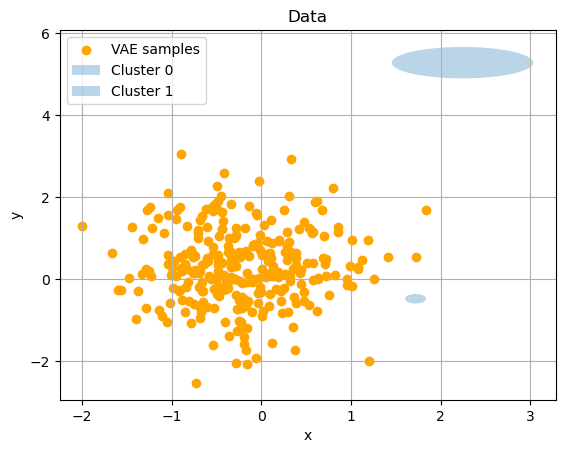

In [53]:

fig, ax = plt.subplots()

ax.scatter(vae_samples[:, 0].detach().cpu().numpy(), vae_samples[:, 1].detach().cpu().numpy(), label='VAE samples', color='orange')

for cluster_num in range(num_clusters):
    cur_cluster_ellipsis = Ellipse(
        m[cluster_num], 
        width=std[cluster_num][0].item(),
        height=std[cluster_num][1].item(),
        alpha=0.3,
        label=f'Cluster {cluster_num}'
    )

    ax.add_patch(cur_cluster_ellipsis)

ax.legend()
ax.grid()
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Data');

In [54]:
def train_on_batch(model, x_batch, y_batch, optimizer, loss_function):
    model.train()
    optimizer.zero_grad()
    
    loss = model.loss(x_batch.to(model.device), y_batch.to(model.device))
    loss.backward()

    optimizer.step()
    return loss.cpu().item()

In [55]:
def train_epoch(train_generator, model, loss_function, optimizer, callback = None):
    epoch_loss = 0
    total = 0
    for it, batch_of_x in enumerate(train_generator):
        batch_loss = train_on_batch(model, batch_of_x, batch_of_x, optimizer, loss_function)
        
        if callback is not None:
            with torch.no_grad():
                callback(model, batch_loss)
            
        epoch_loss += batch_loss*len(batch_of_x)
        total += len(batch_of_x)
    
    return epoch_loss/total

In [56]:

def trainer(count_of_epoch, 
            batch_size, 
            dataset,
            model, 
            loss_function,
            optimizer,
            lr = 0.001,
            callback = None):

    optima = optimizer(model.parameters(), lr=lr)
    
    iterations = tqdm.notebook.tqdm(range(count_of_epoch), desc='epoch')
    iterations.set_postfix({'train epoch loss': np.nan})
    for it in iterations:
        batch_generator = tqdm.notebook.tqdm(
            torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True), 
            leave=False, total=len(dataset)//batch_size+(len(dataset)%batch_size> 0))
        
        epoch_loss = train_epoch(train_generator=batch_generator, 
                    model=model, 
                    loss_function=loss_function, 
                    optimizer=optima, 
                    callback=callback)
        
        iterations.set_postfix({'train epoch loss': epoch_loss})

In [57]:
%load_ext tensorboard
%tensorboard --logdir logs/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6007 (pid 4506), started 0:07:24 ago. (Use '!kill 4506' to kill it.)

In [58]:

optimizer = torch.optim.AdamW

In [59]:
num_epochs = 100
batch_size = 64

In [60]:
import tensorflow as tf

In [61]:
class callback():
    def __init__(self, writer, batch_generator, loss_function, metrics,  delimeter = 100, batch_size=64):
        self.step = 0
        self.writer = writer
        self.delimeter = delimeter
        self.loss_function = loss_function
        self.batch_size = batch_size
        self.batch_generator = batch_generator
        self.metrics = metrics

    def forward(self, model, loss):
        self.step += 1
        with self.writer.as_default():
            tf.summary.scalar('Loss', loss, self.step)
        
          
    def __call__(self, model, loss):
        return self.forward(model, loss)

In [62]:
writer = tf.summary.create_file_writer('./logs/run-0')
trainer(count_of_epoch=num_epochs, 
            batch_size=batch_size, 
            dataset=X_train,
            model=vae, 
            loss_function=None,
            optimizer = optimizer,
            lr = 1e-3,
            callback = callback(writer, X_test, vae.loss, 'Loss/Train', 100, 64))

epoch:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

In [63]:
vae_samples = vae.generate_samples(num_samples=300)

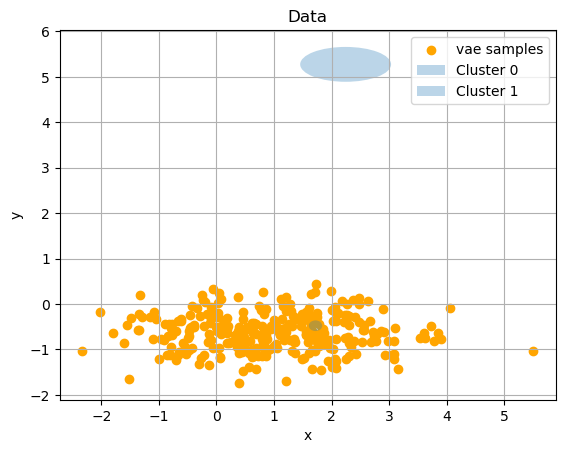

In [64]:

fig, ax = plt.subplots()

ax.scatter(vae_samples[:, 0].detach().cpu().numpy(), vae_samples[:, 1].detach().cpu().numpy(), label='vae samples', color='orange')

for cluster_num in range(num_clusters):
    cur_cluster_ellipsis = Ellipse(
        m[cluster_num], 
        width=std[cluster_num][0].item(),
        height=std[cluster_num][1].item(),
        alpha=0.3,
        label=f'Cluster {cluster_num}'
    )

    ax.add_patch(cur_cluster_ellipsis)

ax.legend()
ax.grid()
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Data');

# Увеличим размерность скрытого пространства

In [65]:
nn_dim = 200
latent_dim = 100

vae = VAE(latent_dim, input_dim, nn_dim)

mae = vae.to(device=device)

In [66]:
writer = tf.summary.create_file_writer('./logs/run-1')
trainer(count_of_epoch=num_epochs, 
            batch_size=batch_size, 
            dataset=X_train,
            model=vae, 
            loss_function=None,
            optimizer = optimizer,
            lr = 1e-3,
            callback = callback(writer, X_test, vae.loss, 'Loss/Train', 100, 64))

epoch:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

In [67]:
vae_samples = vae.generate_samples(num_samples=300)

Text(0.5, 1.0, 'Data')

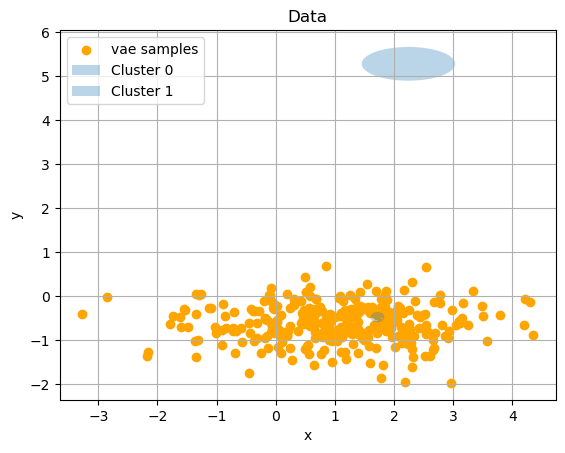

In [68]:

fig, ax = plt.subplots()

ax.scatter(vae_samples[:, 0].detach().cpu().numpy(), vae_samples[:, 1].detach().cpu().numpy(), label='vae samples', color='orange')

for cluster_num in range(num_clusters):
    cur_cluster_ellipsis = Ellipse(
        m[cluster_num], 
        width=std[cluster_num][0].item(),
        height=std[cluster_num][1].item(),
        alpha=0.3,
        label=f'Cluster {cluster_num}'
    )

    ax.add_patch(cur_cluster_ellipsis)

ax.legend()
ax.grid()
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Data')

Что численно, что визуально качество предсказания от увелечния размера латентного пространство не изменилось. Это говорит о том что его размерность уже избыточна

In [69]:
# Увеличим размерность исходного пространства

In [70]:
input_dim = 20
num_clusters = 2
m = getmeans(input_dim, num_clusters)
std = getstd(input_dim, num_clusters)

params = np.stack((m, std), axis = 1)
num_points = 10000
data = plotmixturenorm(params, size = num_points)

dataset_20 = pd.DataFrame()
for i in range(input_dim):
    dataset_20[f'coord{i}'] = data[0][:, i]

In [71]:
test_ratio = 0.2
X_20_train = dataset_20.values[:int(num_points * (1 - test_ratio))].astype(np.float32)
X_20_test = dataset_20.values[int(num_points * (1 - test_ratio)):].astype(np.float32)

In [72]:
X_20_train.shape

(8000, 20)

In [73]:
nn_dim = 200
latent_dim = 10

vae = VAE(latent_dim, input_dim, nn_dim)

mae = vae.to(device=device)

In [74]:
writer = tf.summary.create_file_writer('./logs/run-2')
trainer(count_of_epoch=num_epochs, 
            batch_size=batch_size, 
            dataset=X_20_train,
            model=vae, 
            loss_function=None,
            optimizer = optimizer,
            lr = 1e-3,
            callback = callback(writer, X_test, vae.loss, 'Loss/Train', 100, 64))


epoch:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

In [75]:
vae_samples = vae.generate_samples(num_samples=300)

Text(0.5, 1.0, 'Data')

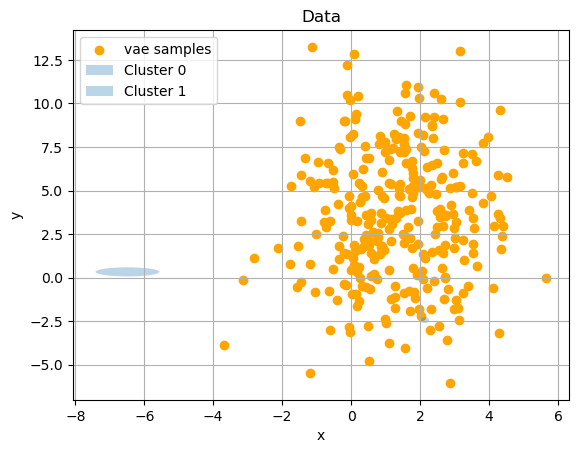

In [76]:

fig, ax = plt.subplots()

ax.scatter(vae_samples[:, 0].detach().cpu().numpy(), vae_samples[:, 1].detach().cpu().numpy(), label='vae samples', color='orange')

for cluster_num in range(num_clusters):
    cur_cluster_ellipsis = Ellipse(
        m[cluster_num], 
        width=std[cluster_num][0].item(),
        height=std[cluster_num][1].item(),
        alpha=0.3,
        label=f'Cluster {cluster_num}'
    )

    ax.add_patch(cur_cluster_ellipsis)

ax.legend()
ax.grid()
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Data')

Увелиение размерности как и ожидалось ухудшило качество восстановления

# Уменьшим размер сети

In [77]:
nn_dim = 20
latent_dim = 10
input_dim = 2
vae = VAE(latent_dim, input_dim, nn_dim)

mae = vae.to(device=device)

In [78]:
writer = tf.summary.create_file_writer('./logs/run-3')
trainer(count_of_epoch=num_epochs, 
            batch_size=batch_size, 
            dataset=X_train,
            model=vae, 
            loss_function=None,
            optimizer = optimizer,
            lr = 1e-3,
            callback = callback(writer, X_test, vae.loss, 'Loss/Train', 100, 64))

epoch:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

In [79]:
vae_samples = vae.generate_samples(num_samples=300)

Text(0.5, 1.0, 'Data')

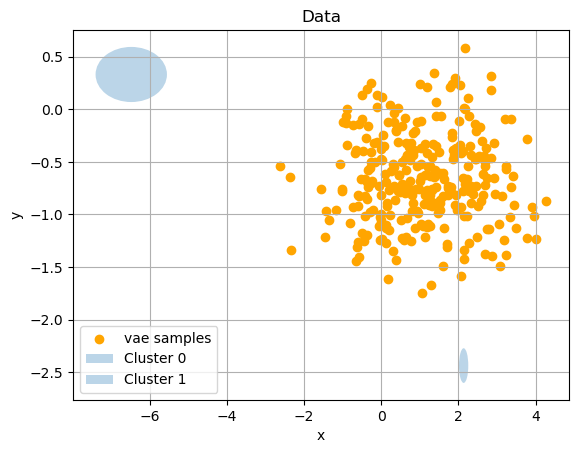

In [80]:

fig, ax = plt.subplots()

ax.scatter(vae_samples[:, 0].detach().cpu().numpy(), vae_samples[:, 1].detach().cpu().numpy(), label='vae samples', color='orange')

for cluster_num in range(num_clusters):
    cur_cluster_ellipsis = Ellipse(
        m[cluster_num], 
        width=std[cluster_num][0].item(),
        height=std[cluster_num][1].item(),
        alpha=0.3,
        label=f'Cluster {cluster_num}'
    )

    ax.add_patch(cur_cluster_ellipsis)

ax.legend()
ax.grid()
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Data')

Изменение размера сети не изменило качество, следовательно размер сети избыточен

In [81]:
nn_dim = 20
latent_dim = 20
input_dim = 4
vae = VAE(latent_dim, input_dim, nn_dim)

mae = vae.to(device=device)

In [82]:

m = getmeans(input_dim, num_clusters)
std = getstd(input_dim, num_clusters)

params = np.stack((m, std), axis = 1)
num_points = 10000
data = plotmixturenorm(params, size = num_points)

dataset = pd.DataFrame()
for i in range(input_dim):
    dataset[f'coord{i}'] = data[0][:, i]
test_ratio = 0.2
X_train = dataset.values[:int(num_points * (1 - test_ratio))].astype(np.float32)
X_test = dataset.values[int(num_points * (1 - test_ratio)):].astype(np.float32)

In [83]:
writer = tf.summary.create_file_writer('./logs/run-4')
trainer(count_of_epoch=num_epochs, 
            batch_size=batch_size, 
            dataset=X_train,
            model=vae, 
            loss_function=None,
            optimizer = optimizer,
            lr = 1e-3,
            callback = callback(writer, X_test, vae.loss, 'Loss/Train', 100, 64))

epoch:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

In [84]:
vae_samples = vae.generate_samples(num_samples=300)

Text(0.5, 1.0, 'Data')

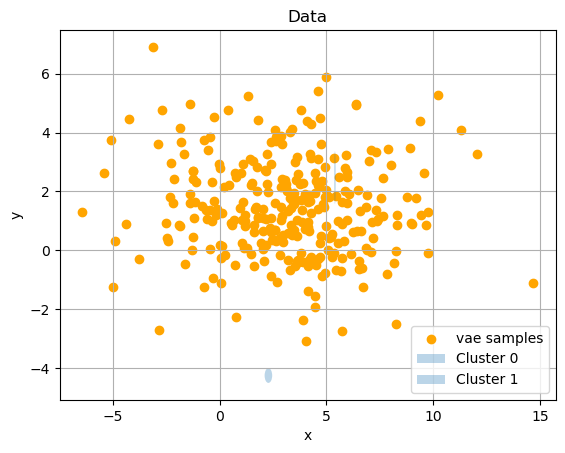

In [85]:

fig, ax = plt.subplots()

ax.scatter(vae_samples[:, 0].detach().cpu().numpy(), vae_samples[:, 1].detach().cpu().numpy(), label='vae samples', color='orange')

for cluster_num in range(num_clusters):
    cur_cluster_ellipsis = Ellipse(
        m[cluster_num], 
        width=std[cluster_num][0].item(),
        height=std[cluster_num][1].item(),
        alpha=0.3,
        label=f'Cluster {cluster_num}'
    )

    ax.add_patch(cur_cluster_ellipsis)

ax.legend()
ax.grid()
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Data')

Пропорциональное увеличение скрытого и исходного пространства привело к уменьшению качества прогноза. Значит связь между этими величинами нелинейная